In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.1


# Environment prep for Colab
 - download git repo 
 - install required pip packages

In [3]:
#!git clone https://github.com/aykhangaffarov/Generative_Models # this is for loading git with correct brach

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')
#!mkdir /content/drive/My\ Drive/Results
#MAIN_SAVE_DIR = '/content/drive/My Drive/Results'
#IMG_DIR = '/content/Generative_Models/data/.CBSD68' #change .qbert here as well



In [5]:
#!mv Generative_Models/data/.CBSD68/CBSD68.tar.bz Generative_Models/data/

# Settings

In [6]:
%env TF_KERAS = 1
import os
sep_local = os.path.sep

import sys
sys.path.append('..'+sep_local+'..')
print(sep_local)

env: TF_KERAS=1
\


In [7]:
os.chdir('..'+sep_local+'..'+sep_local+'..'+sep_local+'..'+sep_local+'..'+sep_local+'..'+sep_local)
print(os.getcwd())

C:\Users\Kriple\PycharmProjects\Generative_Models


In [8]:
#!pip -q install -r requirements.txt

# Unzip

In [9]:
#!tar -xvf data/CBSD68_low2high_LMDB.tar.bz 

In [10]:
#!mv data/.CBSD68_low2high_LMDB/ data/SR

In [11]:
#!ls data/SR

# **Loading** Dataset

In [12]:
from training.generators.from_lmdb.lmdb_image_generator import get_generators

In [13]:
dataset_name='CBSD68_low2high'
lmdb_dir = 'data/.CBSD68_low2high_LMDB'

In [14]:
batch_size = 10
latents_dim = 100
intermediate_dim = 50

In [15]:
from transformation.lmdb_transformer import LmdbTransformer

In [16]:
train_generator, val_generator = get_generators(
        lmdb_dir=lmdb_dir,
        batch_size=batch_size,
        episode_len=None,
        episode_shift=None,
        return_itr=False,
        class_mode='sr'
)

C:\Users\Kriple\PycharmProjects\Generative_Models\transformation\file_image_generator.py:51: UserWarning: No files found
  warnings.warn(msg)


Initializing Iterator training Number of images 55
Initializing Iterator validation Number of images 13


In [17]:
for data in train_generator:
    break
#data = next(train_itr)
print(data.keys())

dict_keys(['xt0', 'xt1', 'dir', 'filename', 'xt0_channels', 'xt0_size', 'xt1_channels', 'xt1_size'])


In [18]:
import matplotlib.pyplot as plt

In [19]:
from PIL import Image

In [20]:
import numpy as np

In [21]:
source_img_size, target_img_size =  data['xt0'][0].shape, data['xt1'][0].shape
source_img_size, target_img_size

(TensorShape([210, 300, 3]), TensorShape([210, 300, 3]))

In [22]:
#source_img_size, target_img_size = (32, 48, 3), (10, 16, 3)

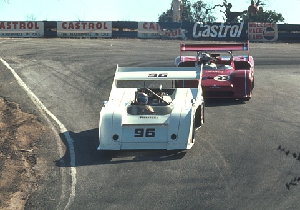

In [23]:
Image.fromarray((data['xt0'][0].numpy() * 255.0).astype(np.uint8), mode='RGB')

In [24]:
image = data['xt1'][0].numpy()

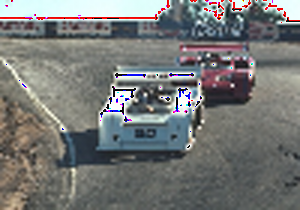

In [25]:
Image.fromarray((data['xt1'][0].numpy() * 255.0).astype(np.uint8), mode='RGB')

In [26]:
import numpy as np
from collections.abc import Iterable
if isinstance(source_img_size, Iterable):
    flat_outputs_shape = np.prod(source_img_size)
flat_outputs_shape    

189000

# Model's Layers definition

In [33]:
kernel_size=4
stride = 2

In [34]:
c = list(map(lambda x: x// (stride*stride), source_img_size[:-1]))
c = (*c, intermediate_dim)
c

(52, 75, 50)

In [35]:
np.product(c)

195000

In [36]:
enc_lays = [
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.UpSampling2D(size=(2, 2)),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latents_dim)
]

dec_lays = [
    tf.keras.layers.Dense(units=np.product(c), activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=c),
    tf.keras.layers.Conv2DTranspose(filters=intermediate_dim, kernel_size=kernel_size, strides=(stride, stride), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=intermediate_dim, kernel_size=kernel_size, strides=(stride, stride), padding="SAME", activation='relu'),
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=kernel_size, strides=(1, 1), padding="SAME")
]

# Model definition

In [37]:
model_name = dataset_name+'_Conv_Pre_Upsampling_LMDB'
#windows
#experiments_dir='..' + sep_local + '..' + sep_local +'..' + sep_local + '..' + sep_local + '..'+sep_local+'experiments'+sep_local + model_name

#linux 
experiments_dir=os.getcwd()+ sep_local  +'experiments'+sep_local + model_name

In [38]:
target_img_size, source_img_size

(TensorShape([210, 300, 3]), TensorShape([210, 300, 3]))

In [39]:
variables_params = \
[
    {
        'name': 'inference',  #'upsampler',
        'inputs_shape':target_img_size,
        'outputs_shape':latents_dim,
        'layers': enc_lays
    }

    ,
    
        {
        'name': 'generative', #'constructive', 
        'inputs_shape':latents_dim,
        'outputs_shape':source_img_size,
        'layers':dec_lays
    }
]

In [40]:
from os.path import abspath
from utils.data_and_files.file_utils import create_if_not_exist
_restore = os.path.join(experiments_dir, 'var_save_dir')
create_if_not_exist(_restore)
absolute = abspath(_restore)
print("Restore_dir",absolute)
absolute = abspath(experiments_dir)
print("Recording_dir",absolute)
print("Current working dir",os.getcwd())

Restore_dir C:\Users\Kriple\PycharmProjects\Generative_Models\experiments\CBSD68_low2high_Conv_Pre_Upsampling_LMDB\var_save_dir
Recording_dir C:\Users\Kriple\PycharmProjects\Generative_Models\experiments\CBSD68_low2high_Conv_Pre_Upsampling_LMDB
Current working dir C:\Users\Kriple\PycharmProjects\Generative_Models


In [41]:
from training.autoencoding_basic.transformative.AE import autoencoder as AE

In [42]:
ae = AE( 
    name=model_name,
    latents_dim=latents_dim,
    batch_size=batch_size,
    variables_params=variables_params, 
    filepath=None,#to restore trained model, set filepath=_restore
    episode_len=1
    )

ResourceExhaustedError: OOM when allocating tensor with shape[3024000,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Add]

In [ ]:
xxx

In [ ]:
ae.compile()
#ae.compile(metrics=None)

# Callbacks

In [ ]:
# added for linux warning suppression
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)


from training.callbacks.trace_image_reconstruction import trace_reconstruction
from training.callbacks.save_model import ModelSaver

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    min_delta=1e-12, 
    patience=12, 
    verbose=1, 
    restore_best_weights=False
)

In [ ]:
ms = ModelSaver(filepath=_restore)

In [ ]:
csv_dir = os.path.join(experiments_dir, 'csv_dir')
create_if_not_exist(csv_dir)
csv_dir = os.path.join(csv_dir, model_name+'.csv')
csv_log = tf.keras.callbacks.CSVLogger(csv_dir, append=True)
absolute = abspath(csv_dir)
print("Csv_dir",absolute)

In [ ]:
image_reconstuction_dir = os.path.join(experiments_dir, 'image_reconstuction_dir')
create_if_not_exist(image_reconstuction_dir)
absolute = abspath(image_reconstuction_dir)
print("image_reconstuction_dir",absolute)

In [ ]:
img_reconst = trace_reconstruction(filepath=image_reconstuction_dir, image=image, gen_freq=5)

# Model Training

In [ ]:
ae.fit(
    x=train_generator,
    input_kw=None,
    steps_per_epoch=5,#int(1e4),
    epochs=5,#int(1e6), 
    verbose=1,
    #callbacks=[ es, ms, csv_log, img_reconst],
    #workers=-1,
    #use_multiprocessing=True,
    #validation_data=val_generator,
    #validation_steps=int(1e4)
    )

In [ ]:
967500 941280